# 米国債10年利回り 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'TNX'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='5y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]

## Moving Median

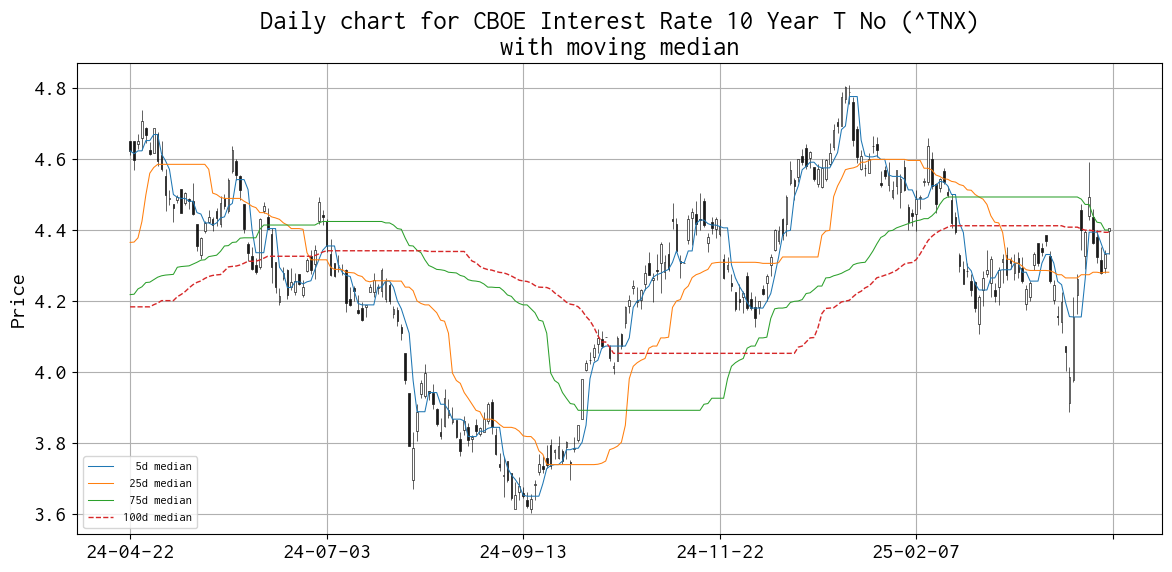

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()
mm300 = df0['Close'].rolling(300).median()
mm500 = df0['Close'].rolling(500).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=1, linestyle='dashed', label='100d median', ax=ax),
    #mpf.make_addplot(mm200[df.index], width=1, linestyle='dashed', label='200d median', ax=ax),
    #mpf.make_addplot(mm300[df.index], width=1, linestyle='dashed', label='300d median', ax=ax),
    #mpf.make_addplot(mm500[df.index], width=1.25, linestyle='dotted', label='500d median', ax=ax),
]   

mpf.plot(df, type='candle', style='default', datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax)

ax.set_title('Daily chart for %s (%s)\nwith moving median' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-17 00:00:00-05:00,4.292,4.344,4.278,4.333,0,0.0,0.0
2025-04-21 00:00:00-05:00,4.397,4.407,4.333,4.405,0,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-04-17 00:00:00-05:00    4.333
2025-04-21 00:00:00-05:00    4.405
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-04-17 00:00:00-05:00      NaN
2025-04-21 00:00:00-05:00    0.072
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-21 00:00:00-05:00    0.007999
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-04-14 00:00:00-05:00    4.262
2025-04-15 00:00:00-05:00    4.323
2025-04-16 00:00:00-05:00    4.323
2025-04-17 00:00:00-05:00    4.333
2025-04-21 00:00:00-05:00    4.364
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-04-14 00:00:00-05:00    4.255
2025-04-15 00:00:00-05:00    4.255
2025-04-16 00:00:00-05:00    4.262
2025-04-17 00:00:00-05:00    4.279
2025-04-21 00:00:00-05:00    4.323
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-04-14 00:00:00-05:00    4.2775
2025-04-15 00:00:00-05:00    4.2845
2025-04-16 00:00:00-05:00    4.2800
2025-04-17 00:00:00-05:00    4.2800
2025-04-21 00:00:00-05:00    4.2935
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-04-14 00:00:00-05:00    4.3125
2025-04-15 00:00:00-05:00    4.3125
2025-04-16 00:00:00-05:00    4.3075
2025-04-17 00:00:00-05:00    4.3075
2025-04-21 00:00:00-05:00    4.3075
Name: Close, dtype: float64

## Robust Bollinger's bands

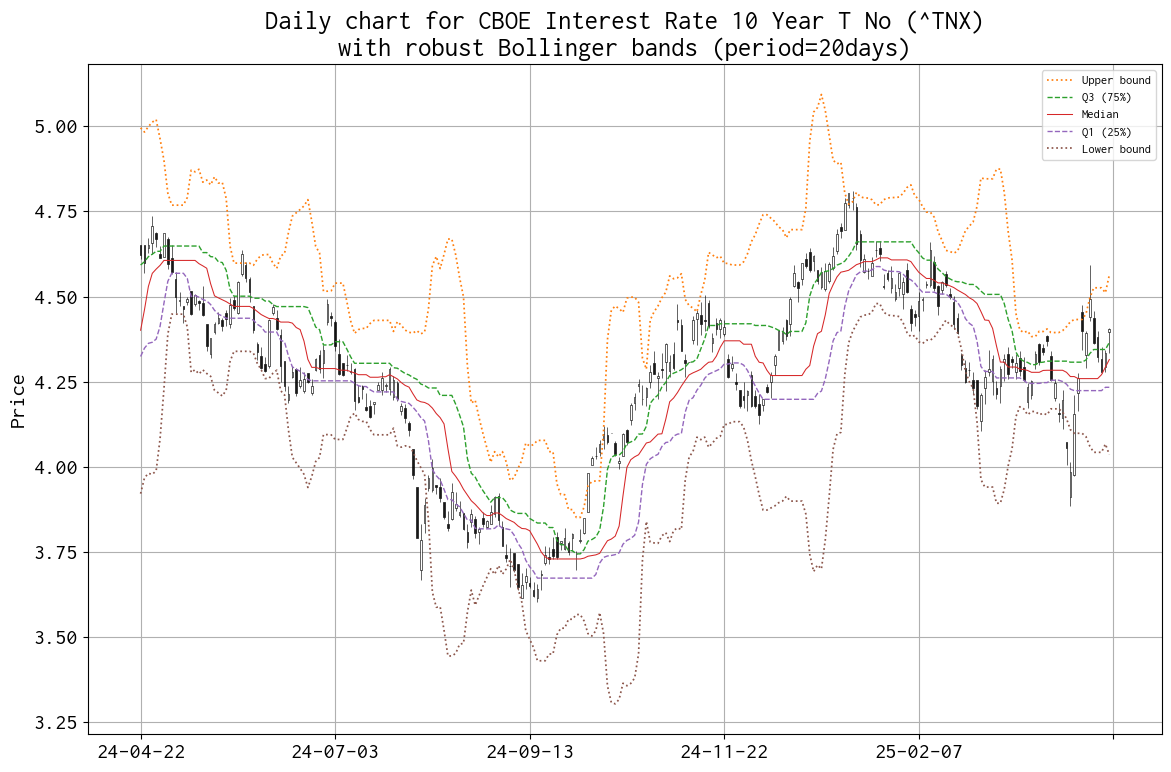

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム & Q-Q プロット

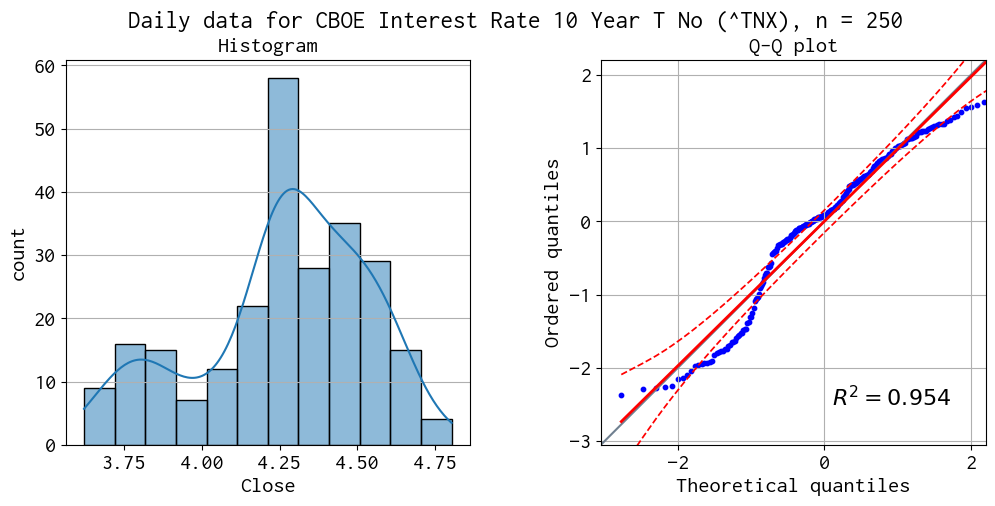

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()